In [84]:
import json
import re

In [85]:
# This file contains 8600ish users Data
# In the form: {'MBTI Type', 'Social Media Posts'}
dataFile = open('formatted_data.json', 'r')

In [86]:
data = []

In [87]:
# loading the json data into a list
for line in dataFile:
    data.append(json.loads(line))

In [88]:
types = []
posts = []

In [89]:
# Separating data into 2 separate lists for preprocessing
# For the most part we process the 'post' data
# we skip the first element as that is only the label
for i in range(1, len(data)):
    types.append(data[i]['Type'])
    posts.append(data[i]['Post'])

In [226]:
# Turning the posts from: 'post1|||post2|||post3'
#                     to: ['post1', 'post2', 'post3']
# expects a list of posts as strings
# returns a list of lists of posts
def vectorize_post_data(posts):
    for index in range(0, len(posts)):
        posts[index] = posts[index].split("|||")
        
    return posts
        
posts = vectorize_post_data(posts)

In [228]:
def remove_hyperTextLinksFromPosts(posts):
    for index in range(0, len(posts)):
        usable_post = [post for post in posts[index] if not re.search(r'^(.)*http(.)*$', post)]
        posts[index] = usable_post
    
    return posts
        
posts = remove_hyperTextLinksFromPosts(posts)

In [230]:
def remove_MBTIClassifiersFromPosts(posts):
    MBTI_regex = r'[\w]*(i|e)(s|n)(f|t)(p|j)[\w]*'
    for i in range(0, len(posts)):
        for j in range(0, len(posts[i])):
            posts[i][j] = re.sub(MBTI_regex, ' ', posts[i][j], flags=re.IGNORECASE)
        
    return posts
    
posts = remove_MBTIClassifiersFromPosts(posts)

In [233]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def isInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

def tokenize_posts(posts):
    tokenizer = RegexpTokenizer(r'\w+')
    
    for i in range(0, len(posts)):
        user_words = []
        for j in range(0, len(posts[i])):
            post = tokenizer.tokenize(posts[i][j])
            for word in post:
                if not isInt(word) and len(word) > 1:
                    user_words.append(word.lower())
                user_words = [w for w in user_words if not w in stop_words]
        posts[i] = user_words
    
    return posts

posts = tokenize_posts(posts)

In [90]:
import pickle

tokenized_posts = []
with open ('tokenized_formatted_data.txt', 'rb') as fp:
    tokenized_posts = pickle.load(fp)

In [91]:
all_words_list = []

for user in tokenized_posts:
    for word in user:
        all_words_list.append(word)


In [92]:
from collections import Counter

In [93]:
freq_list = Counter(all_words_list)
dictionary = freq_list.most_common(10000)

In [94]:
dictionary = list(zip(*dictionary))[0]

In [95]:
nums = range(0, 10000)
word_int = dict(zip(dictionary, nums))

In [10]:
x_vals = []

for user in tokenized_posts:
    x_vals.append([word_int[x] for x in user if x in word_int.keys()])

In [96]:
intro_extro = [word[0:1] for word in types[0:len(types)]]
bin_intro_extro = []
for letter in intro_extro:
    if (letter == 'I'):
        bin_intro_extro.append(0)
    else:
        bin_intro_extro.append(1)

In [97]:
import numpy as np
import random
random.seed(673)

x = np.array(x_vals)
random.shuffle(x)
test_data = x[:1500]
train_data = x[1500:]

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [98]:
from keras.utils.np_utils import to_categorical

y = np.asarray(bin_intro_extro).astype('float32')
random.shuffle(y)
y_test = y[:1500]
y_train = y[1500:]

In [99]:
x_val = x_train[:1500]
x_partial_train = x_train[1500:]

y_val = y_train[:1500]
y_partial_train = y_train[1500:]

In [100]:
from keras import models
from keras import layers
import tensorflow as tf

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu', input_shape = (10000,)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [105]:
model = build_model()
with tf.device('/gpu:0'):
    history = model.fit(x_partial_train, y_partial_train, epochs = 20, batch_size = 64, validation_data=(x_val, y_val))

Train on 5675 samples, validate on 1500 samples
Epoch 1/20
5675/5675 [==============================] - 2s 317us/step - loss: 0.5883 - acc: 0.7556 - val_loss: 0.5599 - val_acc: 0.7733
Epoch 2/20
5675/5675 [==============================] - 1s 186us/step - loss: 0.5534 - acc: 0.7700 - val_loss: 0.5483 - val_acc: 0.7733
Epoch 3/20
5675/5675 [==============================] - 1s 180us/step - loss: 0.5352 - acc: 0.7707 - val_loss: 0.5634 - val_acc: 0.7733
Epoch 4/20
5675/5675 [==============================] - 1s 180us/step - loss: 0.5030 - acc: 0.7713 - val_loss: 0.5847 - val_acc: 0.7733
Epoch 5/20
5675/5675 [==============================] - 1s 182us/step - loss: 0.4877 - acc: 0.7723 - val_loss: 0.6017 - val_acc: 0.7733
Epoch 6/20
5675/5675 [==============================] - 1s 191us/step - loss: 0.4702 - acc: 0.7729 - val_loss: 0.6257 - val_acc: 0.7733
Epoch 7/20
5675/5675 [==============================] - 1s 183us/step - loss: 0.4464 - acc: 0.7755 - val_loss: 0.6708 - val_acc: 0.7733


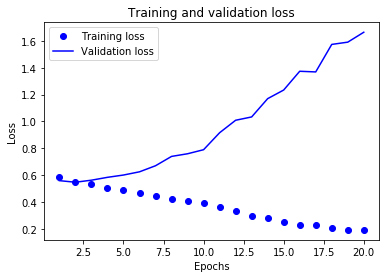

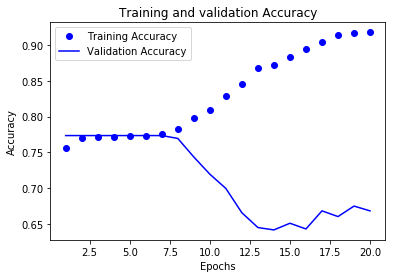

In [106]:
import matplotlib.pyplot as plt

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

train_acc = history_dict['acc']
val_acc   = history_dict['val_acc']

epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [315]:
#K-Fold Validation
k = 4

# // is floor div operator
num_val_samples = len(x_train) // k

for num_epochs in range(1, 20):
    print('Epoch:', num_epochs)
    all_scores = []
    all_loss = []
    for i in range(k):
        print('processing fold #', i)
        val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

        partial_train_data = np.concatenate(
            [x_train[:i * num_val_samples],
             x_train[(i + 1) * num_val_samples:]],
            axis=0)
        partial_train_targets = np.concatenate(
            [y_train[:i * num_val_samples],
             y_train[(i + 1) * num_val_samples:]],
            axis=0)

        model = build_model()
        with tf.device('/gpu:0'):
            model.fit(partial_train_data, partial_train_targets,
                epochs=num_epochs, batch_size=64,verbose = 1)

            val_loss, val_acc = model.evaluate(val_data, val_targets, verbose = 1)

        all_loss.append(val_loss)
        all_scores.append(val_acc)

    print ("Accuracy Mean:", np.mean(all_scores))
    print ("Loss Mean:", np.mean(all_loss))

Epoch: 1
processing fold # 0
Epoch 1/1
1793/1793 [==============================] - 3s 2ms/step
processing fold # 1
Epoch 1/1
1793/1793 [==============================] - 3s 2ms/step
processing fold # 2
Epoch 1/1
1793/1793 [==============================] - 3s 2ms/step
processing fold # 3
Epoch 1/1
1793/1793 [==============================] - 3s 2ms/step
Accuracy Mean: 0.767010596765198
Loss Mean: 0.5550258878059581
Epoch: 2
processing fold # 0
Epoch 1/2
5382/5382 [==============================] - 8s 1ms/step - loss: 0.5957 - acc: 0.7534
Epoch 2/2
1793/1793 [==============================] - 3s 2ms/step
processing fold # 1
Epoch 1/2
5382/5382 [==============================] - 8s 1ms/step - loss: 0.6034 - acc: 0.7345
Epoch 2/2
1793/1793 [==============================] - 3s 2ms/step
processing fold # 2
Epoch 1/2
5382/5382 [==============================] - 8s 1ms/step - loss: 0.6174 - acc: 0.7068
Epoch 2/2
1793/1793 [==============================] - 3s 2ms/step
processing fold # 3
Ep

KeyboardInterrupt: 

In [114]:
model = build_model()
with tf.device('/gpu:0'):
    model.fit(x_train, y_train, epochs=4, batch_size=256)

Epoch 1/4
7175/7175 [==============================] - 2s 213us/step - loss: 0.5804 - acc: 0.7534
Epoch 2/4
7175/7175 [==============================] - 1s 110us/step - loss: 0.5559 - acc: 0.7663
Epoch 3/4
7175/7175 [==============================] - 1s 109us/step - loss: 0.5387 - acc: 0.7706
Epoch 4/4
7175/7175 [==============================] - 1s 112us/step - loss: 0.5118 - acc: 0.7721


In [115]:
results = model.evaluate(x_test, y_test)
results

1500/1500 [==============================] - 0s 285us/step


[0.5671261951128642, 0.7566666669845581]